# Introduction

[Tacoma](pics/tacoma.png)

Anomaly detection on aggregated sensor data collected from a vehicle's engine control unit via OBD-II connection.

# 1. Prerequiste Libraries and Settings

In [2]:
%matplotlib inline
from util import *

# 2. Load Data

In [3]:
def load_data(filename):
    """
    Reads data from disk and returns both a raw and normalized version.
    
    Args:
        filename (str): The path of the file.
    
    Returns:
        A tuple of the raw data frame and the normalized data frame.
    """
    data = pd.read_csv(filename).drop(['time', 'intake_air_temp'], axis=1)
    return data

In [4]:
data = load_data("data/sensor-log.csv")

In [5]:
# data

# 3. Preprocessing of Data

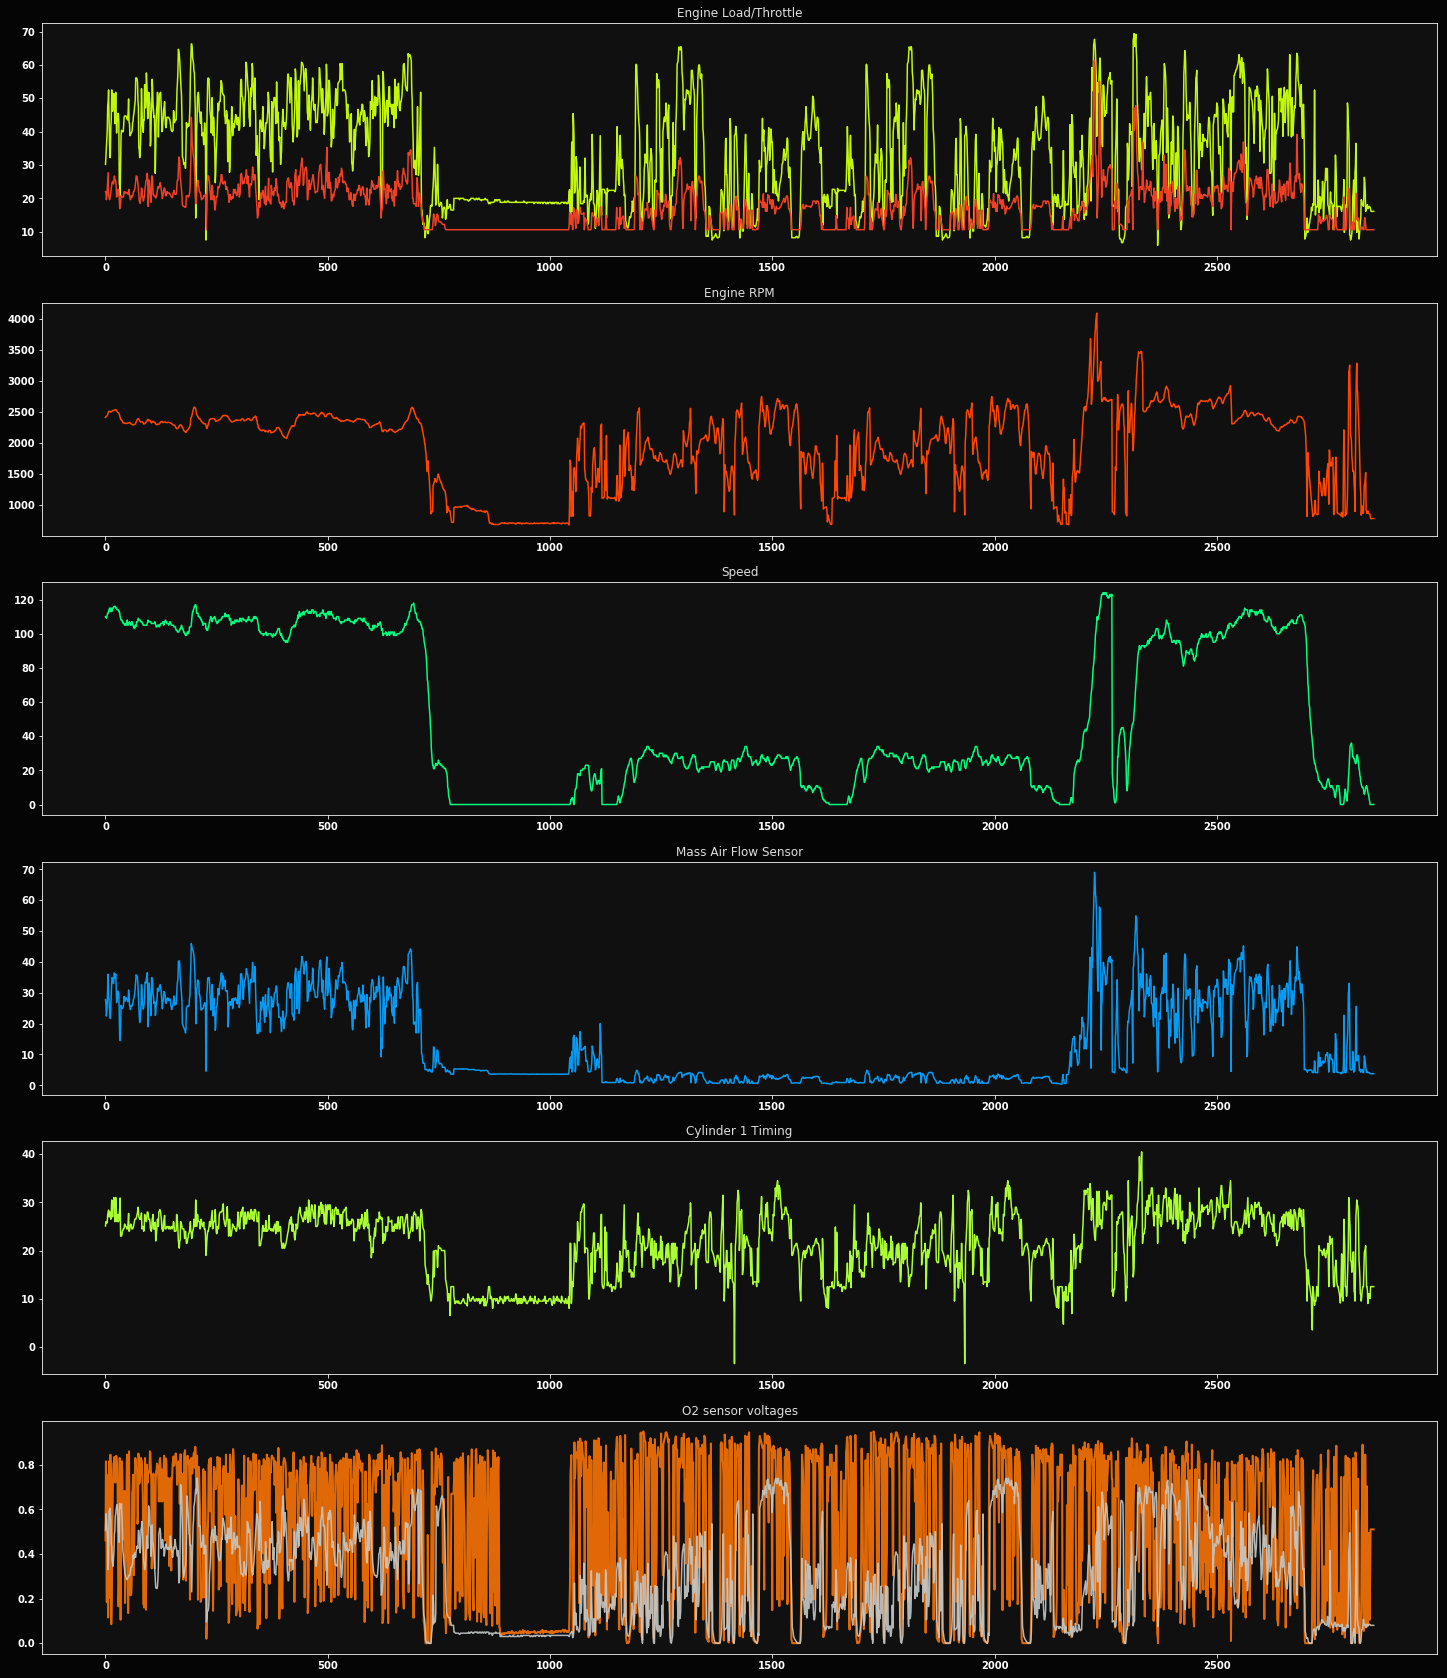

In [6]:
fig, ax = plt.subplots(6, figsize=(25, 30))
fig.set_facecolor('#050505')

plot_sensor_data(ax[0], data, 'engine_load')
plot_sensor_data(ax[0], data, 'throttle')
plot_sensor_data(ax[1], data, 'rpm')
plot_sensor_data(ax[2], data, 'speed')
plot_sensor_data(ax[3], data, 'maf')
plot_sensor_data(ax[4], data, 'timing_c1')
plot_sensor_data(ax[5], data, 'o2_sensor_voltage', alpha=0.9, linewidth=2)
plot_sensor_data(ax[5], data, 'o2_sensor_voltage2', alpha=0.9)
    
plt.show()

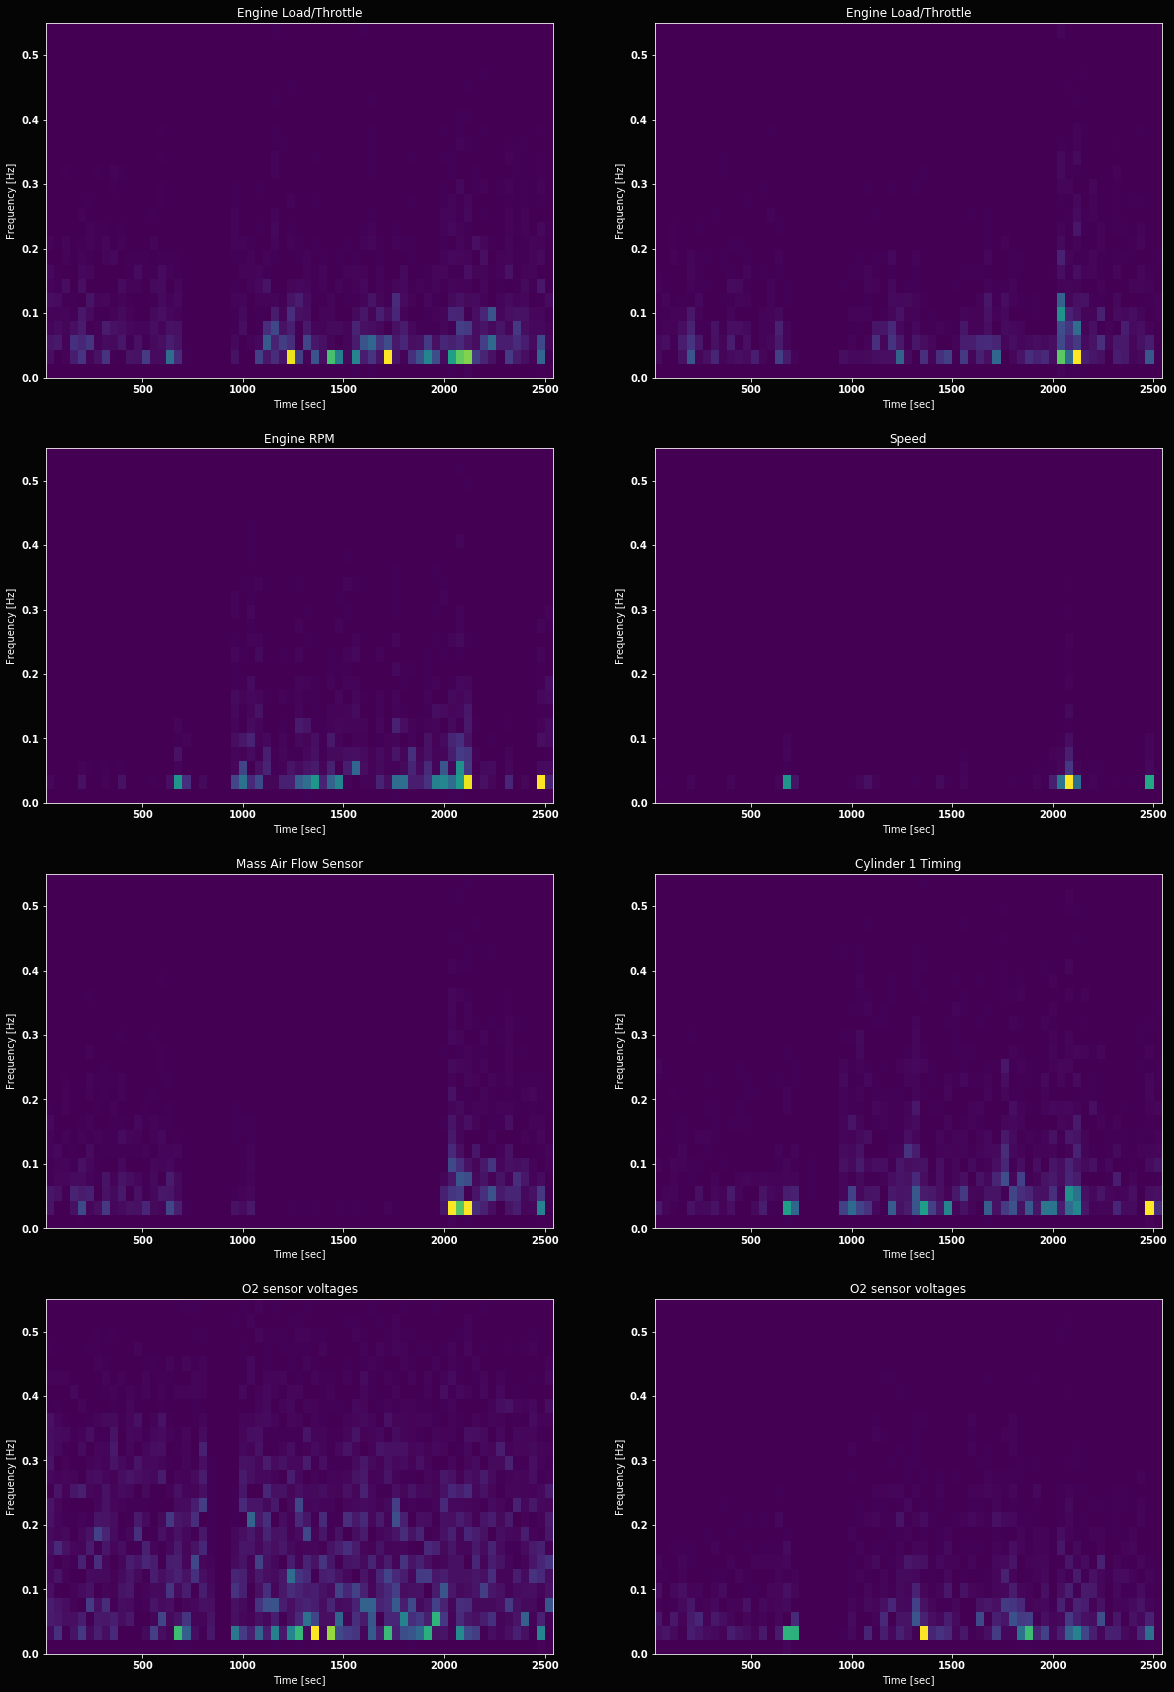

In [7]:
fig, ax = plt.subplots(4,2, figsize=(20,30))
fig.set_facecolor('#050505')

plot_spectrogram(ax[0, 0], data, 'engine_load')
plot_spectrogram(ax[0, 1], data, 'throttle')
plot_spectrogram(ax[1, 0], data, 'rpm') 
plot_spectrogram(ax[1, 1], data, 'speed')
plot_spectrogram(ax[2, 0], data, 'maf')
plot_spectrogram(ax[2, 1], data, 'timing_c1')
plot_spectrogram(ax[3, 0], data, 'o2_sensor_voltage')
plot_spectrogram(ax[3, 1], data, 'o2_sensor_voltage2')
plt.show()

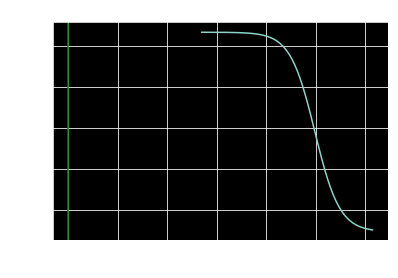

In [8]:

plot_butterworth()

In [9]:
def preprocess_data_filters(data):
    """
    Runs a low-pass filter on data to remove noise and normalizes the data to have unit std and null mean.
    
    Args:
        data (DataFrame): The data frame to process.
        
    Returns:
        A tuple of the data frame (low-pass) and the normalized data frame.
    """
    def low_pass(data) :
        b, a = signal.butter(5, .01, 'low', analog=False)
        return signal.lfilter(b, a, data.values)        

    filter_processed_data = data.copy()
    for i in data.columns:
        filter_processed_data[i] = low_pass(data[i])
        
    filter_normalized_data = (filter_processed_data - filter_processed_data.mean())/filter_processed_data.std()
    
    return filter_processed_data, filter_normalized_data


In [10]:
filter_processed_data, filter_normalized_data = preprocess_data_filters(data)

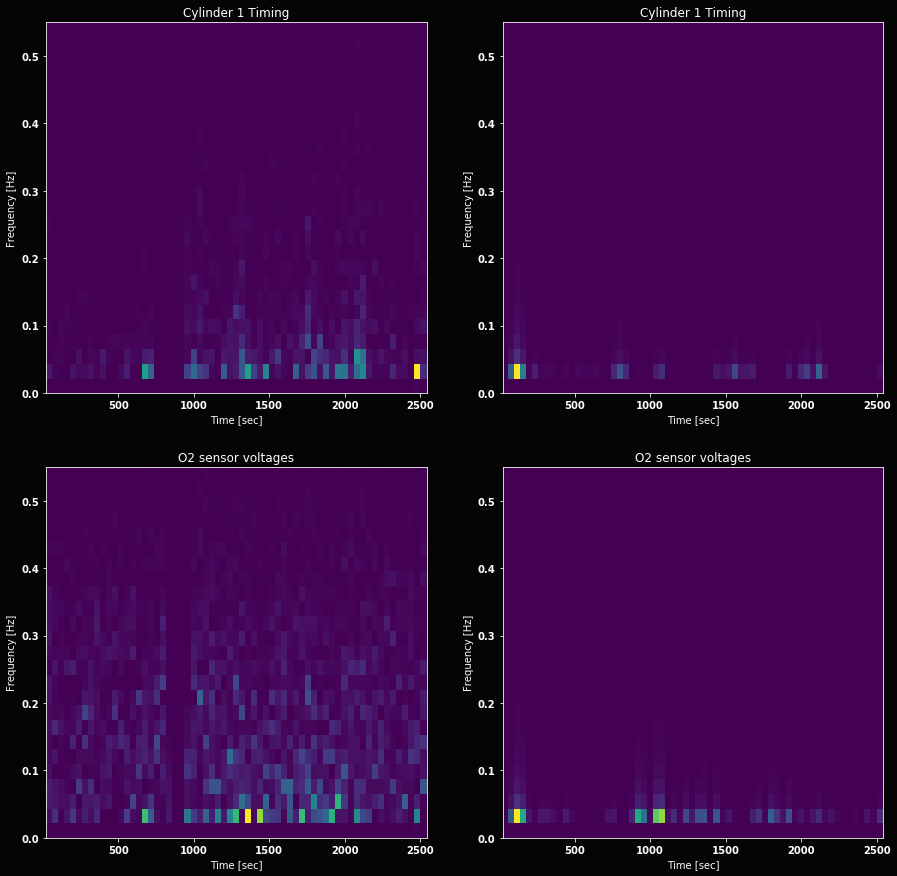

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
fig.set_facecolor('#050505')

plot_spectrogram(ax[0, 0], data, 'timing_c1')
plot_spectrogram(ax[0, 1], filter_processed_data, 'timing_c1')

plot_spectrogram(ax[1, 0], data, 'o2_sensor_voltage')
plot_spectrogram(ax[1, 1], filter_processed_data, 'o2_sensor_voltage')

plt.show()

In [12]:
def preprocess_data(data):
    """
    Runs a moving average on data to remove noise and normalizes the data to have unit std and null mean.
    
    Args:
        data (DataFrame): The data frame to process.
        
    Returns:
        A tuple of the data frame (low-pass) and the normalized data frame.
    """
    def ma(data, N=10):        
        return np.ma.average(data, np.ones(N)/N)
        
    processed_data = data.rolling(window=20, center=True, min_periods=1).mean()
        
    normalized_data = (processed_data - processed_data.mean())/processed_data.std()
    
    return processed_data, normalized_data

In [13]:
processed_data, normalized_data = preprocess_data(data)

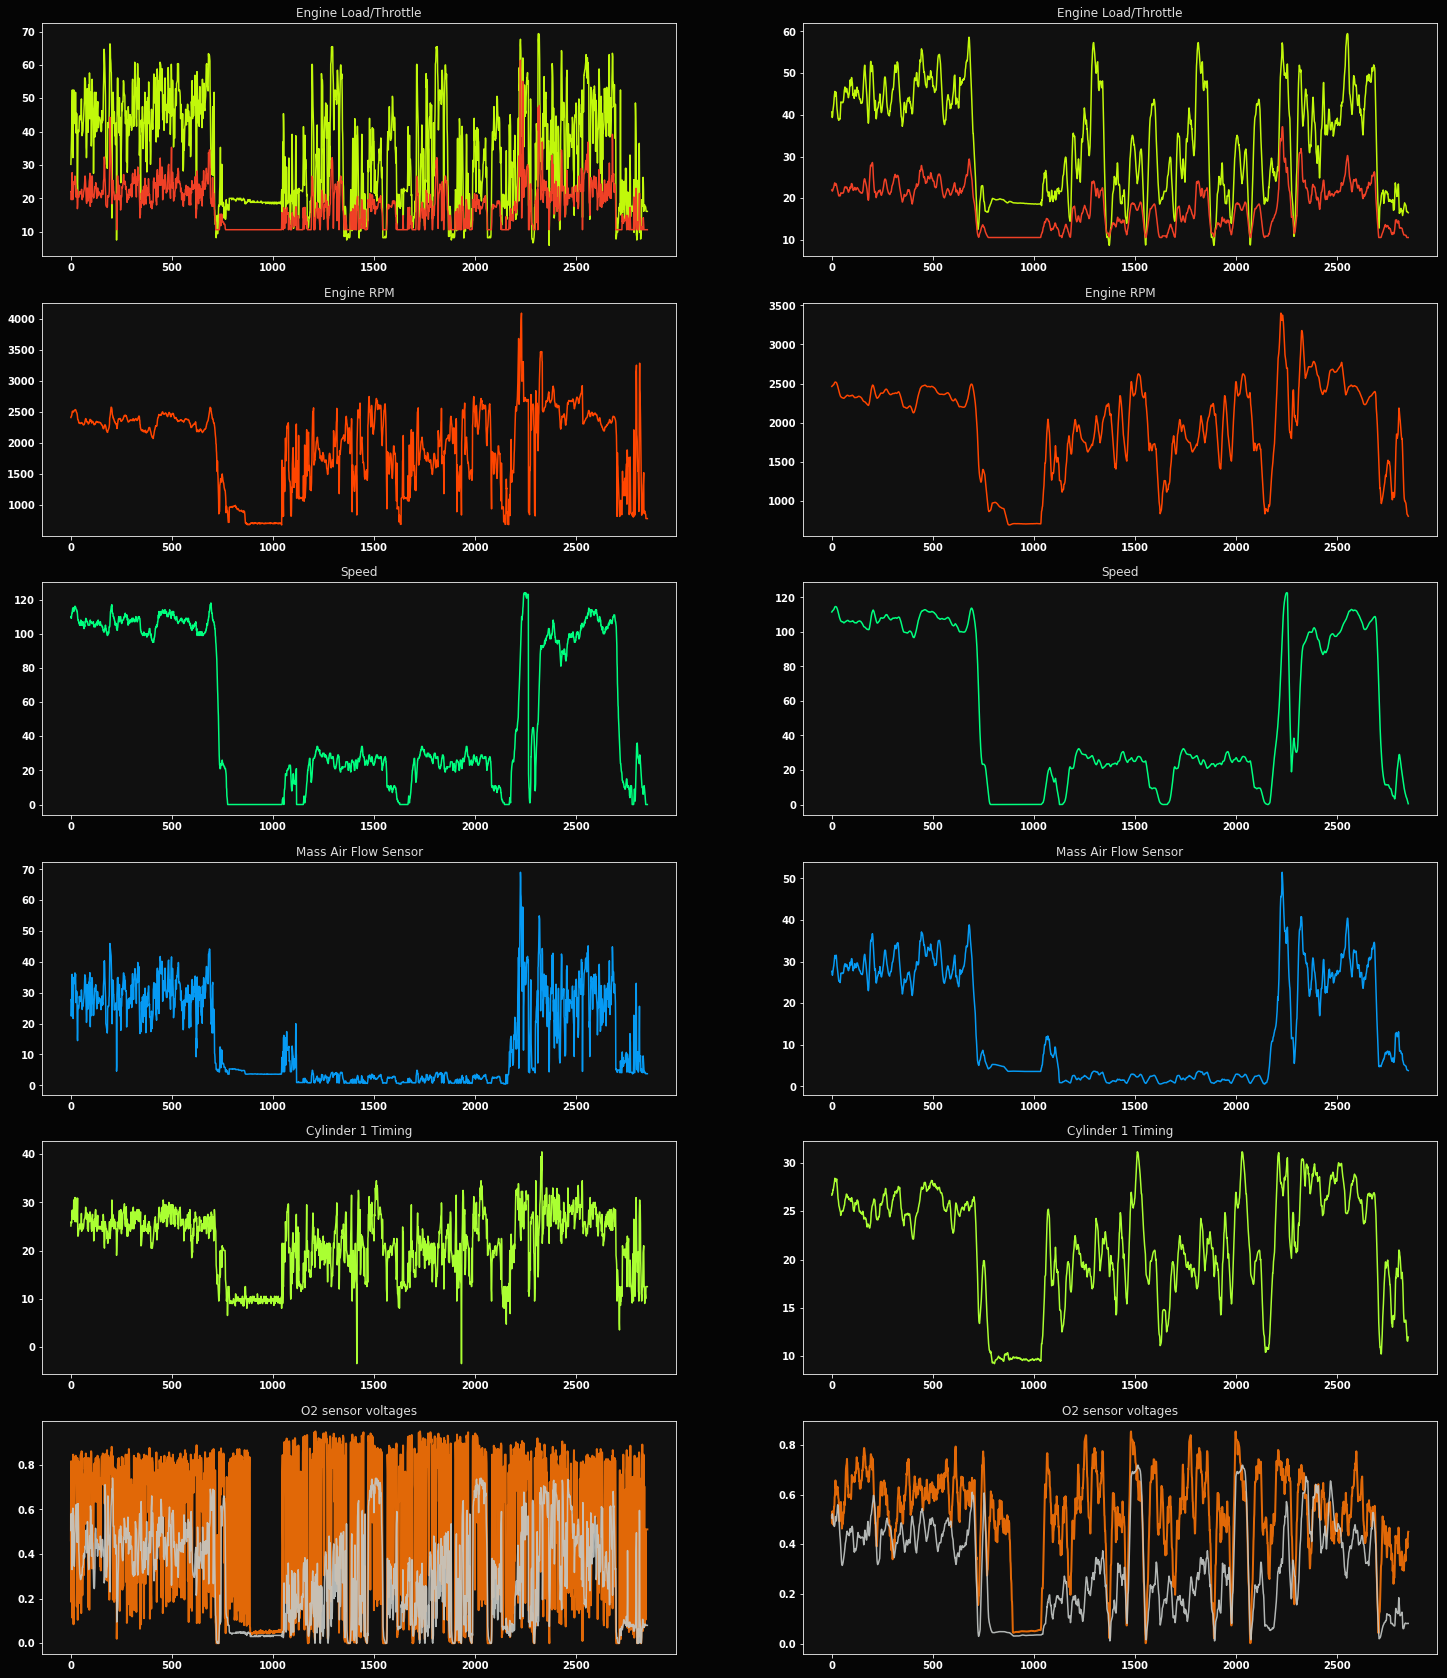

In [14]:
fig, ax = plt.subplots(6, 2, figsize=(25, 30))
fig.set_facecolor('#050505')

plot_sensor_data(ax[0,0], data, 'engine_load')
plot_sensor_data(ax[0,1], processed_data, 'engine_load')

plot_sensor_data(ax[0, 0], data, 'throttle')
plot_sensor_data(ax[0, 1], processed_data, 'throttle')

plot_sensor_data(ax[1, 0], data, 'rpm')
plot_sensor_data(ax[1, 1], processed_data, 'rpm')

plot_sensor_data(ax[2, 0], data, 'speed')
plot_sensor_data(ax[2, 1], processed_data, 'speed')

plot_sensor_data(ax[3, 0], data, 'maf')
plot_sensor_data(ax[3, 1], processed_data, 'maf')

plot_sensor_data(ax[4, 0], data, 'timing_c1')
plot_sensor_data(ax[4, 1], processed_data, 'timing_c1')

plot_sensor_data(ax[5, 0], data, 'o2_sensor_voltage', alpha=0.9, linewidth=2)
plot_sensor_data(ax[5, 1], processed_data, 'o2_sensor_voltage', alpha=0.9, linewidth=2)

plot_sensor_data(ax[5, 0], data, 'o2_sensor_voltage2', alpha=0.9)
plot_sensor_data(ax[5, 1], processed_data, 'o2_sensor_voltage2', alpha=0.9)
    
plt.show()

# 4. Create Test and Training Data sets

In [15]:
def split_data(data, split_factor=0.7):
    """
    Split the dataset into a train and test dataset
    
    Args:
        data (DataFrame): The data frame to split into train and test.
        split_factor: The contiguous portion of data starting from the first row to make training data.
        
    Returns:
        A tuple of train and test split according to split_factor.
    """
    # Split data into test and train.
    N = data.shape[0]
    split_index = int(split_factor*N)

    train = data[:split_index]
    test = data[split_index:]
    
    return train, test


def prepare_dataset(data, window):
    """
    Prepare a windowed data set from a data set.
    
    :param data: a data frame with F features
    :param window: the length of a window
    :returns: a data frame in the format CW: channel x width, where channel = features and width = window
    """
    values = data.values
    num_features = data.shape[1]
    # Concats observations in a window
    windowed_data = np.zeros((data.shape[0], data.shape[1], window)).astype(np.float32)
    for i in range(len(data)):
        for j in range(window):
            if i - j  >= 0:
                windowed_data[i, :, j] = values[i - j, :]
            else:
                windowed_data[i, :, j] = np.zeros(data.shape[1])

    return windowed_data

In [16]:
# Window size - the bigger this value is, the longer our network will "retain" past information i.e. it will take longer
# for newer state to become significant but it will also mean we will use the time dependency factor more into account.
window = 20

train_data, test_data = split_data(normalized_data)

# Convert our data into windowed formats
train = prepare_dataset(train_data, window)
test = prepare_dataset(test_data, window)

# Create an iterator, which will feed our data in a batched fashion into MXNet
batch_size = 64
train_data_loader = mx.gluon.data.DataLoader(train, batch_size, last_batch='keep', shuffle=True)
test_data_loader = mx.gluon.data.DataLoader(test, batch_size, last_batch='keep', shuffle=True)

train_dataset = mx.gluon.data.dataset.ArrayDataset(train)
test_dataset = mx.gluon.data.dataset.ArrayDataset(test)

# 5. Define Model

In [17]:
ctx = mx.gpu() # use mx.cpu() on machines with no GPU
    
class AutoEncoder(nn.Block):
    def __init__(self, N, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)            

        with self.name_scope():
            self.encoder = nn.Sequential()                    
            with self.encoder.name_scope():                
                self.encoder.add(gluon.nn.Conv1D(N, 5, layout='NCW', activation='relu'))
                self.encoder.add(gluon.nn.Conv1D(N*2, 4, layout='NCW', activation='relu'))
                self.encoder.add(gluon.nn.Conv1D(N*4, 3, layout='NCW', activation='relu'))               
            
            self.decoder = nn.Sequential()
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Conv1DTranspose(N*4, 3, layout='NCW', activation='relu'))
                self.decoder.add(gluon.nn.Conv1DTranspose(N*2, 4, layout='NCW', activation='relu'))    
                self.decoder.add(gluon.nn.Conv1DTranspose(N, 5, layout='NCW', activation='relu'))

    def forward(self, x):            
            x = self.encoder(x)
            x = self.decoder(x)
            return x


# This parameter is used to scale the network architecture.
N = train_data.shape[1]        
model = AutoEncoder(N)

# Use the non default Xavier parameter initializer
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

# Use Adam optimizer for training
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

# Similarly to previous example we will use L2 loss for evaluation
L = gluon.loss.L2Loss()

# 6. Train Model

In [18]:
def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = data
        output = model(data)            
        loss = L(output, label)     
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return loss_avg


<IPython.core.display.Javascript object>


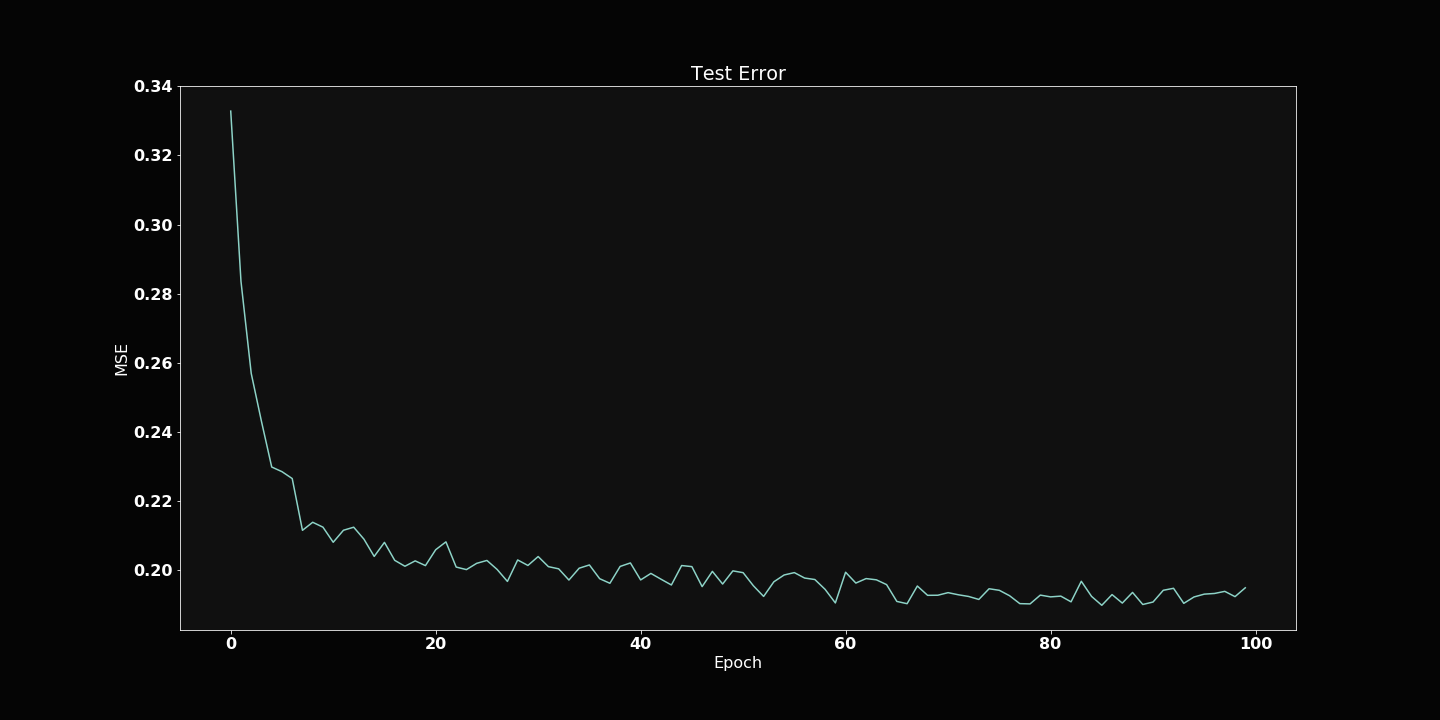

IntProgress(value=0, bar_style='success', description='Progress:', layout=Layout(height='45px', width='1000px'…

FloatProgress(value=0.0, bar_style='danger', description='Error:', layout=Layout(height='45px', width='1000px'…

<IPython.core.display.Javascript object>


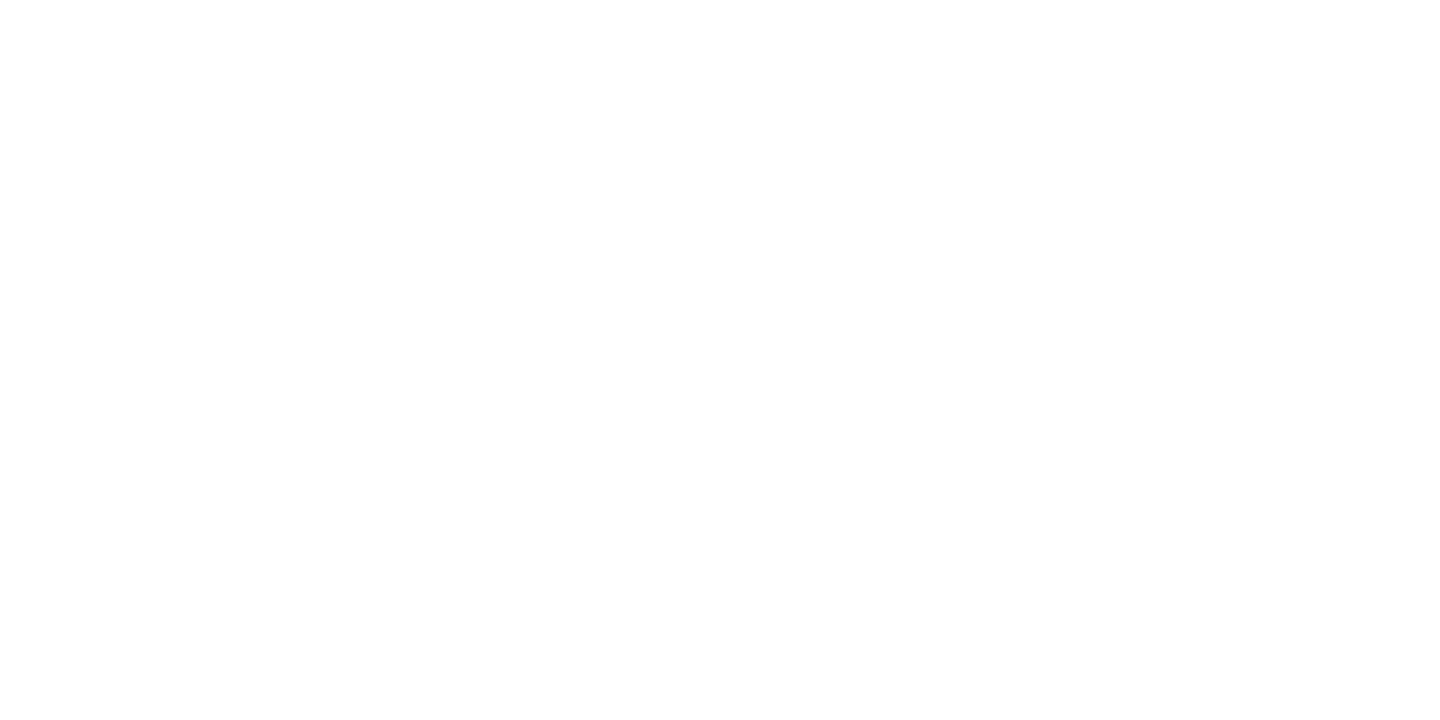

In [19]:
# Plot for the Mean Square Error 
%matplotlib notebook

epochs = 100

fig, ax = setup_mse_plot()
progress_widget, mse_widget = create_widgets(epochs)
display(progress_widget, mse_widget)


all_test_mse = []
# Gluon training loop
for e in range(epochs):
    
    # Training loop.
    for i, df in enumerate(train_data_loader):
        df = df.as_in_context(ctx)
        label = df
        with autograd.record():
            output = model(df)
            loss = L(output, label)
            loss.backward()
        trainer.step(batch_size)     
    # Evalulate Accuracy.
    test_mse = evaluate_accuracy(test_data_loader, model, L)
    all_test_mse.append(test_mse)
        
    # Visualizations of the progress
    #print("Epoch: {} MSE: {}".format(e, test_mse))
    progress_widget.value += 1
    # Update Training Error bar (TODO Update this to a rolling average delta or something)
    mse_widget.value = test_mse
    mse_widget.max = max(test_mse, mse_widget.max)    
    
    # Update Training error visualization        
    plot_mse(fig, ax, all_test_mse)    

In [20]:
%matplotlib inline
plt.ioff()  # Interactive mode off

# 7. Visualize Anomalies in Regular Data

In [21]:
# Helper method running predictions in a batched fashion
def predict(to_predict, L):    
    errors = []   
    for i, data in enumerate(to_predict):
        data = data.as_in_context(ctx)
        out = model(data)        
        error = L(out, data).asnumpy()
        errors = np.append(errors, error.flatten())
    return errors

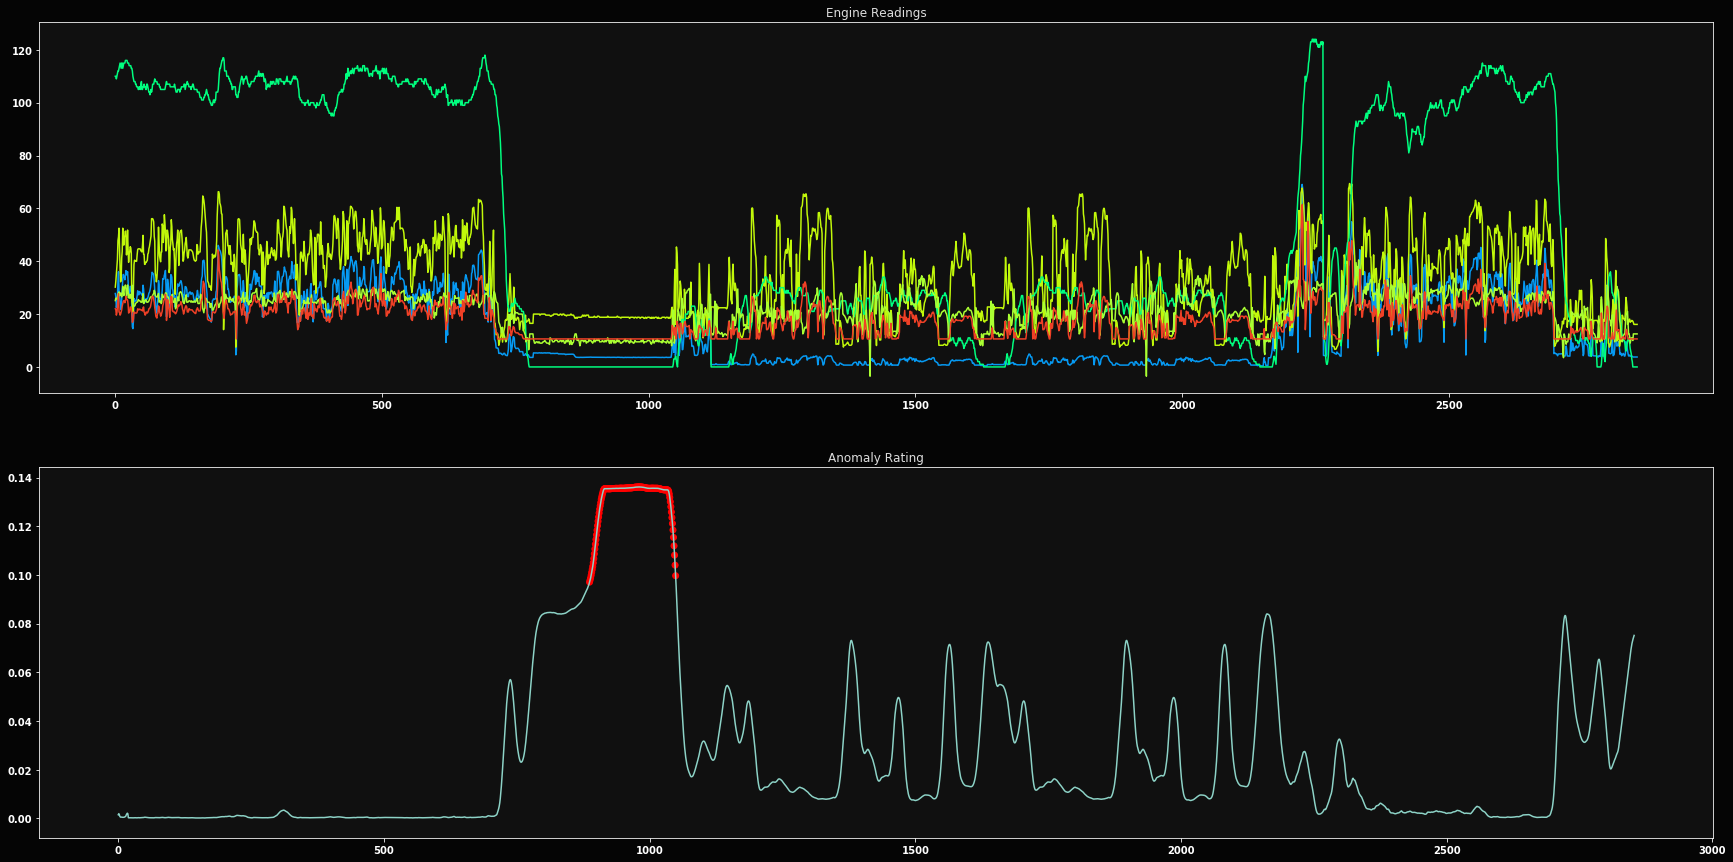

In [24]:
predictions_raw_data = data
predictions_normalized_data = normalized_data

predictions_data = prepare_dataset(predictions_normalized_data, window)
predictions_data_loader = mx.gluon.data.DataLoader(predictions_data, batch_size, last_batch='keep', shuffle=False)
errors = predict(predictions_data_loader, L)

visualize_anomalies(predictions_raw_data, errors, threshold_constant=2)

#def f(threshold_constant=2.0):
#    visualize_anomalies(predictions_raw_data, errors, threshold_constant=threshold_constant)

#threshold_slider = widgets.FloatSlider(
#    min=0,
#    max=3.0,
#    value=2.0,
#    description="Threshold",
#   layout=Layout(width='1000px', height='45px'))      
#interact(f, threshold_constant=threshold_slider)

# 8. Simulate an Anomaly

/home/ANT.AMAZON.COM/vishaalk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


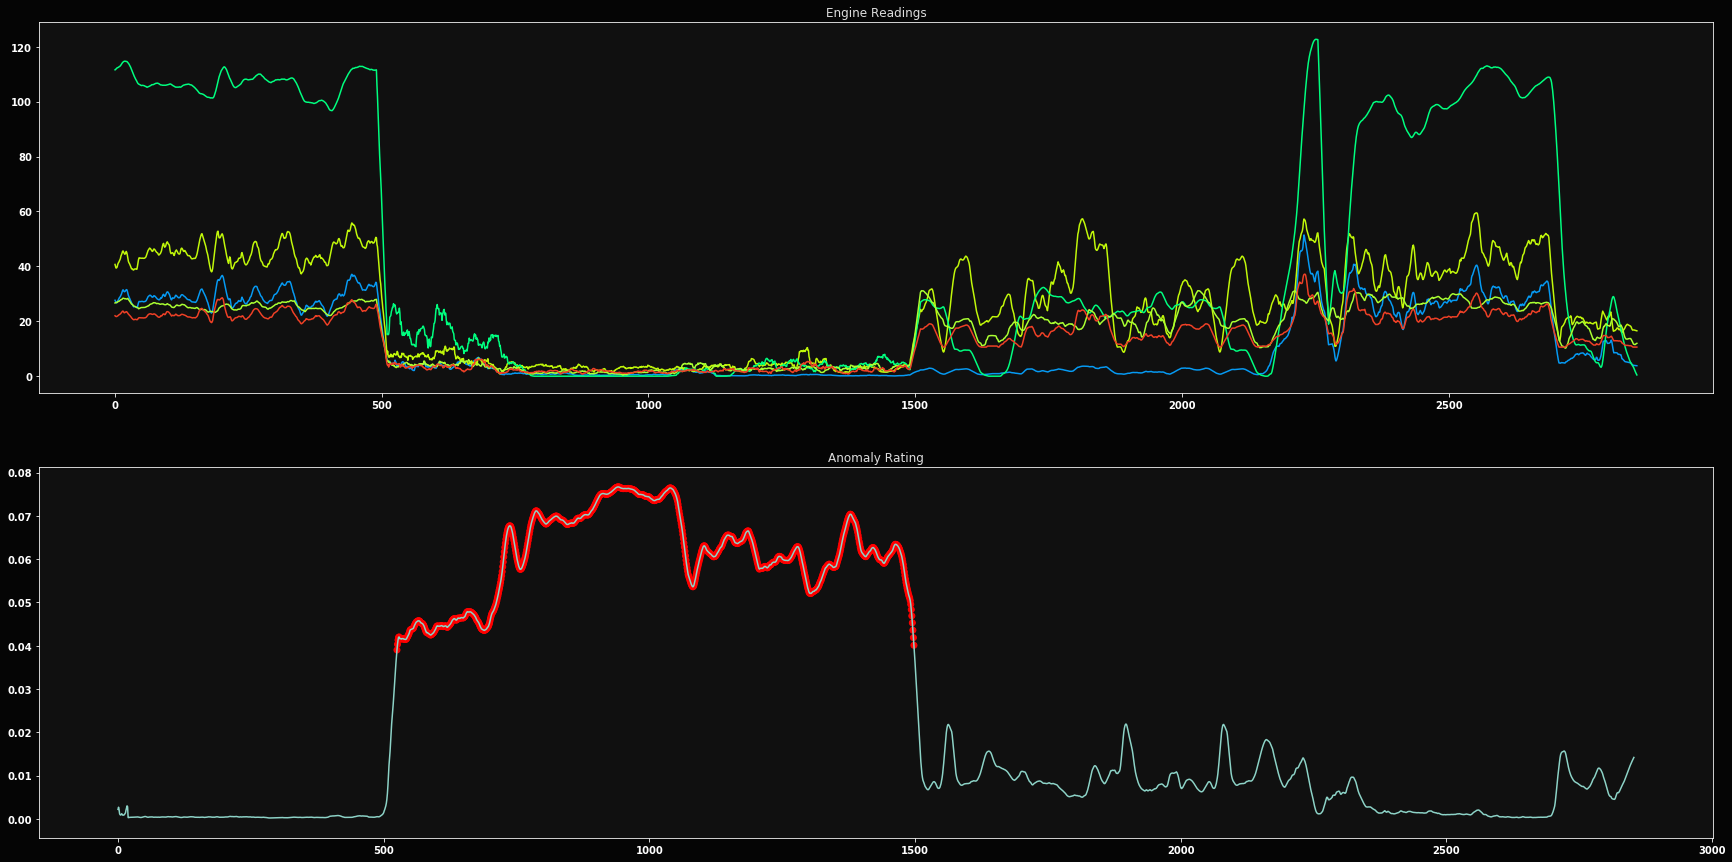

In [25]:
def simulate_anomaly(data):
    """
    Simulates something unusual. This is very artificial.
    """        
    updated_data = data.copy()    
    mu, sigma = .30, 0.25
    for i in data.columns:
        updated_data[i][500:1500] = updated_data[i][500:1500]*(np.random.normal(mu, sigma, updated_data['maf'].shape)**2)[500:1500]
    
    processed_data = updated_data.rolling(window=20, center=True, min_periods=1).mean()
    normalized_data = (processed_data - processed_data.mean())/processed_data.std()
    
    return updated_data, processed_data, normalized_data   

predictions_raw, predictions_raw_data, predictions_normalized = simulate_anomaly(data)

predictions_dataset = prepare_dataset(predictions_normalized, window)
predictions_data_loader = mx.gluon.data.DataLoader(predictions_dataset, batch_size, last_batch='keep', shuffle=False)
errors = predict(predictions_data_loader, L)

visualize_anomalies(predictions_raw_data, errors, threshold_constant=.5)

#def f(threshold_constant=0.5):
#    visualize_anomalies(predictions_raw_data, errors, threshold_constant=threshold_constant)

#threshold_slider = widgets.FloatSlider(
#    min=0,
#    max=1,
#    value=.5,
#    description="Threshold",
#   layout=Layout(width='1000px', height='45px'))      
#interact(f, threshold_constant=threshold_slider)

# References
Fault detection using transient machine signals Markus Timusk.

https://zone.biblio.laurentian.ca/bitstream/10219/2277/1/Mohamed%20-%20FinalManuscript_Reduced_Edit_GraduateStudies.pdf

https://stats.stackexchange.com/questions/358710/awful-performance-of-lstm-on-noisy-time-series-after-stationarisation

https://medium.com/datadriveninvestor/multivariate-time-series-using-var-f1f5058831b8

https://en.wikipedia.org/wiki/Autoencoder

https://www.quora.com/Whats-the-difference-between-a-Variational-Autoencoder-VAE-and-an-Autoencoder

https://musiclab.chromeexperiments.com/Spectrogram/

https://web.cse.ohio-state.edu/~wang.77/papers/Liu-Wang.icassp17.pdf

https://arxiv.org/pdf/1810.09133.pdf

https://www.researchgate.net/publication/334223668_Time_Series_Anomaly_Detection_with_Variational_Autoencoders

https://arxiv.org/pdf/1907.01702.pdf

https://arxiv.org/pdf/1806.09612.pdf

http://www.diva-portal.org/smash/record.jsf?pid=diva2%3A789498&dswid=-9537

http://www.diva-portal.org/smash/get/diva2:789498/FULLTEXT01.pdf

https://zone.biblio.laurentian.ca/bitstream/10219/2323/1/Zhang_Bo_Master_Thesis.pdf

https://www.researchgate.net/profile/M_Lipsett/publication/228625518_Automated_Operating_Mode_Classification_for_Online_Monitoring_Systems/links/547499b10cf2778985abeac0.pdf

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8181533
https://zone.biblio.laurentian.ca/bitstream/10219/3206/1/Alex%20Rose%20-%20Thesis%20%28post-defense%29%20v2.pdf

https://arxiv.org/pdf/1806.09612.pdf